# Group Assignment 1: KNN

### Data Preprocessing (please upload dataset first)

In [ ]:
# import library
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chisquare as cs 
import scipy
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)




> Import Data



In [ ]:
df = pd.read_csv("COVID-19BehaviorData_CAN_USA.csv")
df = df.replace(r'^\s*$', np.nan, regex=True)



> Remove Columns



In [ ]:
# calculate missing value percentage in each column, and flag those > 70%
df_sum = pd.DataFrame(df.isna().sum()).reset_index()
df_sum["null_%"] = df_sum[0]/df.shape[0]
df_sum[df_sum["null_%"] > 0.7]

,index,0,null_%
15,i5a_health,26219,0.909592
16,i6_health,26219,0.909592
17,i7b_health,26509,0.919653
18,i8_health,26559,0.921388


In [ ]:
# have a close look at i14_health_other
df['i14_health_other'].value_counts()

__NA__                               26645
Retail                                  87
Office                                  59
retail                                  38
office                                  29
                                     ...  
On my property only.                     1
Tourisme / excursions maritimes          1
home manager                             1
Accounting, only person in office        1
Grocery cashier supervisor               1
Name: i14_health_other, Length: 1367, dtype: int64

There are more than 70% of the records are missing in i5a_health, i6_health, i7b_health, i8_health, so they should be removed. Also, after looking into the data, over 70% of the records in i14_health_other column are '_NA_', therefore it should also be disregarded.

In [ ]:
df_new = df.drop(['i5a_health', 'i6_health', 'i7b_health', 'i8_health', 'i14_health_other'], axis = 1)

In [ ]:
# columns irrelevant to predict the target variable are dropped
df_new = df_new.drop(['region_state', 'Index', 'RecordNo', 'endtime', 'qweek', 'i3_health', 'i4_health', 'i5_health_1', 'i5_health_2', 'i5_health_3', 'i5_health_4', 'i5_health_5', 'i5_health_99'], axis = 1)

In [ ]:
df_new.shape

(28825, 61)



> Missing Value



In [ ]:
# how many records are missing in target variable i9_health?
df_new['i9_health'].isna().sum()/df_new.shape[0]

0.06699045967042498

Since there are only 6.7% of records are missing in i9_health, we filter out these missing rows. The missing records in other columns are replaced with NaN 

In [ ]:
df_new = df_new[df_new['i9_health'].notnull()]
df_new = df_new.replace(np.nan, 'NaN')



> Aggregate Columns



In [ ]:
# aggregate i14 and employment_status -> Catagorize each row into Work From Home, Not Work From Home and Not Working.
df_new['emp_stat'] = np.where((df_new['i14_health_1']=='Yes') | (df_new['i14_health_2']=='Yes') |(df_new['i14_health_3']=='Yes')|
                          (df_new['i14_health_4']=='Yes') | (df_new['i14_health_5']=='Yes') |(df_new['i14_health_6']=='Yes')|
                          (df_new['i14_health_7']=='Yes') | (df_new['i14_health_8']=='Yes') |(df_new['i14_health_9']=='Yes')|
                          (df_new['i14_health_10']=='Yes') | (df_new['i14_health_96']=='Yes') |(df_new['i14_health_98']=='Yes'), 'not_wfh','')
for index, row in df_new.iterrows():
        if row['i14_health_99']=='Yes' and row['employment_status'] not in ['Not working', 'Retired', 'Unemployed']:
            df_new.at[index,'emp_stat']='wfh'
for index, row in df_new.iterrows():
        if row['emp_stat']=='':
            df_new.at[index,'emp_stat']='not_working'
df_new = df_new.drop(['i14_health_1', 'i14_health_2', 'i14_health_3', 'i14_health_4', 'i14_health_5', 'i14_health_6', 'i14_health_7', 'i14_health_8', 'i14_health_9', 'i14_health_10', 'i14_health_96', 'i14_health_98', 'i14_health_99', 'employment_status'], axis=1)


In [ ]:
# only use d1_health_99 -Pre-existing health conditions? 
df_new = df_new.drop(['d1_health_1','d1_health_2', 'd1_health_3', 'd1_health_4', 'd1_health_5', 'd1_health_6', 'd1_health_7', 'd1_health_8', 'd1_health_9', 'd1_health_10', 'd1_health_11', 'd1_health_12', 'd1_health_13', 'd1_health_98'], axis=1)


In [ ]:
df_new.shape

(26894, 34)

# Exploratory Data Analysis

---





## Relationship between i9_health and categorical variables



In [ ]:
#Perform Chi-square test on catagorical variables. Eliminate non-significant variables with p-value<0.05
cat_cols = [x for x in df_new.columns.to_list() if x not in ['i1_health', 'i2_health', 'i7a_health', 'i13_health', 'weight', 'age']]
cat_cols
for item in cat_cols:
  crosstab = pd.crosstab(df_new['i9_health'], df_new[item])
  pvalue = stats.chi2_contingency(crosstab)[1]
  if pvalue > 0.05:
    print('The p-value of chi-sqaure test between i9 and {} is {}'.format(item, pvalue))
  else:
    pass

All categorical variables are significant.

**Catagory wise response to i9_health**

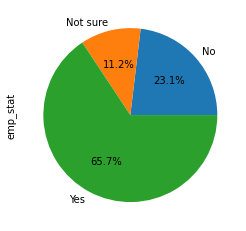

In [ ]:
#Exploration of response with respect to work status - Cannot work from home
data = df_new[df_new['emp_stat']=='not_wfh']
data=data.groupby("i9_health")["emp_stat"].count()
data.plot.pie(autopct="%.1f%%");

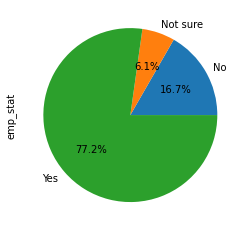

In [ ]:
#Exploration of response with respect to work status - Can work from home
data = df_new[df_new['emp_stat']=='wfh']
data=data.groupby("i9_health")["emp_stat"].count()
data.plot.pie(autopct="%.1f%%");

In [ ]:
crosstab1 = pd.crosstab(df_new["emp_stat"], df_new["i9_health"], margins=False)
crosstab1_norm = crosstab1.div(crosstab1.sum(axis=1), axis=0)
crosstab1_norm

i9_health,No,Not sure,Yes
emp_stat,,,
not_wfh,0.231032,0.112169,0.656799
not_working,0.175830,0.097783,0.726387
wfh,0.166886,0.060885,0.772230


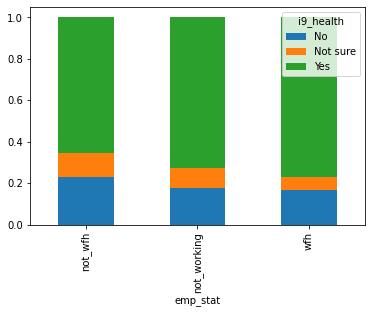

In [ ]:
crosstab1_norm.plot(kind = 'bar', stacked = True)

**Heatmap for Catagorical Predictors**

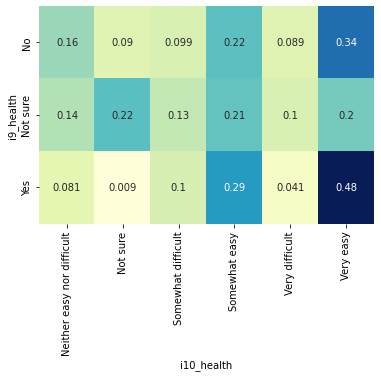

In [ ]:
#i10_health
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.i10_health]), cmap="YlGnBu", annot=True, cbar=False)"""
crosstab_i10 = pd.crosstab(df_new["i9_health"], df_new["i10_health"], margins=False)
crosstab_i10_norm = crosstab_i10.div(crosstab_i10.sum(axis=1), axis=0)

sns.heatmap(crosstab_i10_norm, cmap="YlGnBu", annot=True, cbar=False)

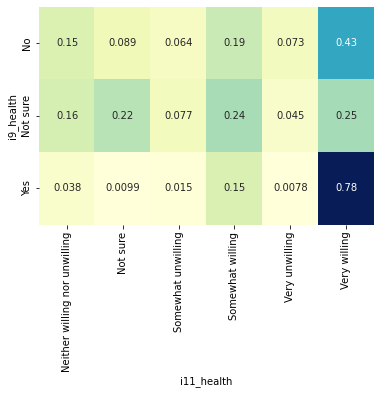

In [ ]:
#i11_health
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.i11_health]), cmap="YlGnBu", annot=True, cbar=False)"""
crosstab_i11 = pd.crosstab(df_new["i9_health"], df_new["i11_health"], margins=False)
crosstab_i11_norm = crosstab_i11.div(crosstab_i11.sum(axis=1), axis=0)

sns.heatmap(crosstab_i11_norm, cmap="YlGnBu", annot=True, cbar=False)

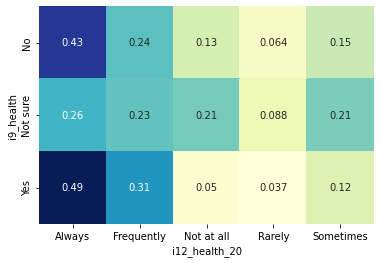

In [ ]:
#i12_health_20 -> all i12_health seems to follow a similar trnd. People who follow the proper hygine practices seem to be more willing to isolate
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.i12_health_20]), cmap="YlGnBu", annot=True, cbar=False)"""

crosstab_i12 = pd.crosstab(df_new["i9_health"], df_new["i12_health_20"], margins=False)
crosstab_i12_norm = crosstab_i12.div(crosstab_i12.sum(axis=1), axis=0)

sns.heatmap(crosstab_i12_norm, cmap="YlGnBu", annot=True, cbar=False)

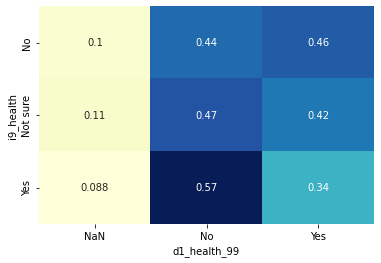

In [ ]:
#d1_health_99
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.d1_health_99]), cmap="YlGnBu", annot=True, cbar=False)"""

crosstab_d1 = pd.crosstab(df_new["i9_health"], df_new["d1_health_99"], margins=False)
crosstab_d1_norm = crosstab_d1.div(crosstab_d1.sum(axis=1), axis=0)

sns.heatmap(crosstab_d1_norm, cmap="YlGnBu", annot=True, cbar=False)

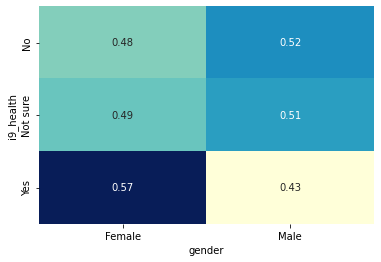

In [ ]:
#gender
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.gender]), cmap="YlGnBu", annot=True, cbar=False)"""
crosstab_g = pd.crosstab(df_new["i9_health"], df_new["gender"], margins=False)
crosstab_g_norm = crosstab_g.div(crosstab_g.sum(axis=1), axis=0)

sns.heatmap(crosstab_g_norm, cmap="YlGnBu", annot=True, cbar=False)

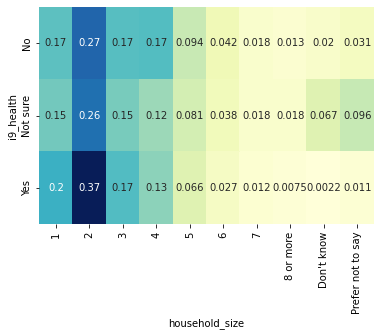

In [ ]:
#household_size
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.household_size]), cmap="YlGnBu", annot=True, cbar=False)"""
crosstab_hs = pd.crosstab(df_new["i9_health"], df_new["household_size"], margins=False)
crosstab_hs_norm = crosstab_hs.div(crosstab_hs.sum(axis=1), axis=0)

sns.heatmap(crosstab_hs_norm, cmap="YlGnBu", annot=True, cbar=False)

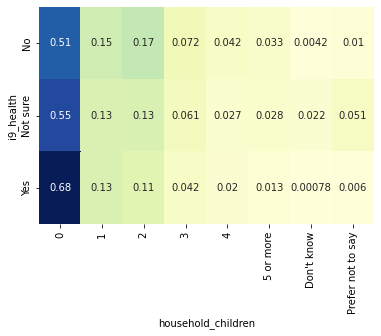

In [ ]:
#household_children
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.household_children]), cmap="YlGnBu", annot=True, cbar=False)"""
crosstab_hc = pd.crosstab(df_new["i9_health"], df_new["household_children"], margins=False)
crosstab_hc_norm = crosstab_hc.div(crosstab_hc.sum(axis=1), axis=0)

sns.heatmap(crosstab_hc_norm, cmap="YlGnBu", annot=True, cbar=False)

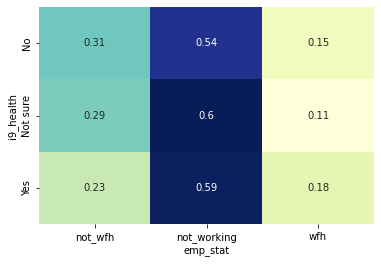

In [ ]:
#emp_stat
"""sns.heatmap(pd.crosstab([df_new.i9_health], [df_new.emp_stat]), cmap="YlGnBu", annot=True, cbar=False)"""

crosstab_emp = pd.crosstab(df_new["i9_health"], df_new["emp_stat"], margins=False)
crosstab_emp_norm = crosstab_emp.div(crosstab_emp.sum(axis=1), axis=0)

sns.heatmap(crosstab_emp_norm, cmap="YlGnBu", annot=True, cbar=False)

- Most catagorical variables are significant and can be used for KNN classification
- EDA has uncovered interesting trends in response based on Gender, Employement etc.


## Relationship between i9_health and other numeric variables



### 1. Age

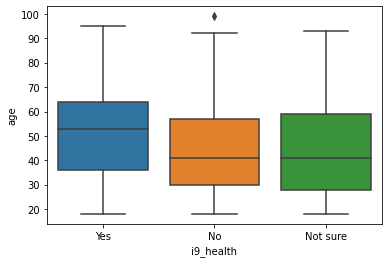

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="age", x="i9_health", data=df_new)

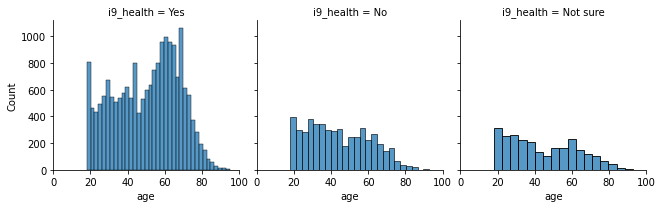

In [ ]:
cond_plot = sns.FacetGrid(data=df_new, col='i9_health', col_wrap=4)
cond_plot.map(sns.histplot, 'age')
cond_plot.set(xlim=(0,100))

In [ ]:
# one-way anova between age and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['age'], df_new[df_new['i9_health'] == 'No']['age'], df_new[df_new['i9_health'] == 'Not sure']['age'])
print(fvalue, pvalue)

387.8585094680111 8.68949543116269e-167


### i1_health

[(0.0, 10.0)]

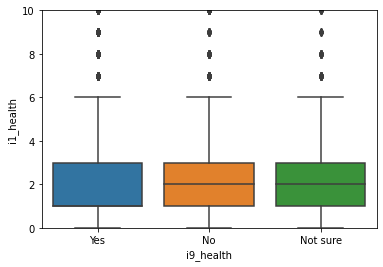

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="i1_health", x="i9_health", data=df_new)
ax.set(ylim=(0, 10))

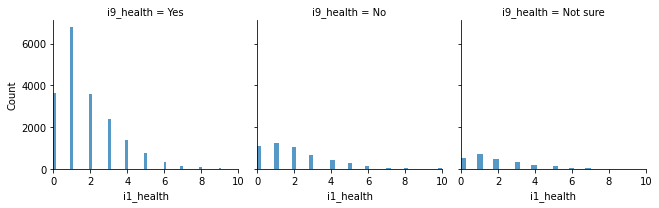

In [ ]:
cond_plot = sns.FacetGrid(data=df_new, col='i9_health', col_wrap=4)
cond_plot.map(sns.histplot, 'i1_health')
cond_plot.set(xlim=(0,10))

In [ ]:
# one-way anova between i1_health and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['i1_health'], df_new[df_new['i9_health'] == 'No']['i1_health'], df_new[df_new['i9_health'] == 'Not sure']['i1_health'])
print(fvalue, pvalue)

15.748839352140875 1.4600526313759848e-07


### i2_health

[(0.0, 25.0)]

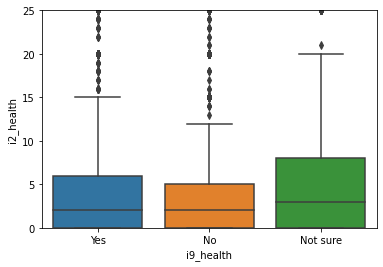

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="i2_health", x="i9_health", data=df_new)
ax.set(ylim=(0, 25))

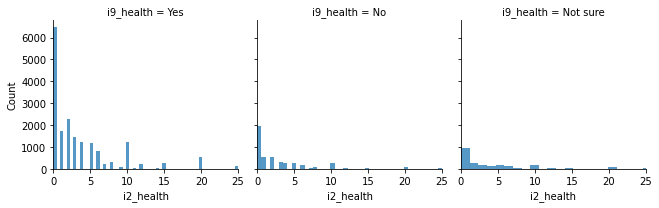

In [ ]:
cond_plot = sns.FacetGrid(data=df_new, col='i9_health', col_wrap=4)
cond_plot.map(sns.histplot, 'i2_health')
cond_plot.set(xlim=(0,25))

In [ ]:
# one-way anova between i2_health and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['i2_health'], df_new[df_new['i9_health'] == 'No']['i2_health'], df_new[df_new['i9_health'] == 'Not sure']['i2_health'])
print(fvalue, pvalue)

20.627912329804737 1.117574687617769e-09


### i7a_health

[(0.0, 8.0)]

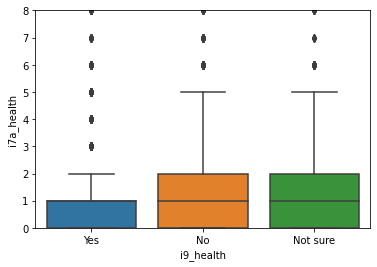

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="i7a_health", x="i9_health", data=df_new)
ax.set(ylim=(0, 8))

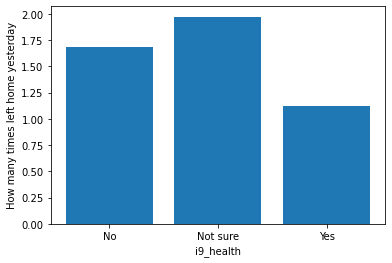

In [ ]:
df_mean = df_new.groupby('i9_health')['i7a_health'].mean()
df_mean = df_mean.reset_index()
plt.bar(df_mean['i9_health'],df_mean['i7a_health'])
plt.xlabel("i9_health")
plt.ylabel("How many times left home yesterday")
plt.show()

In [ ]:
# one-way anova between i7a_health and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['i7a_health'], df_new[df_new['i9_health'] == 'No']['i7a_health'], df_new[df_new['i9_health'] == 'Not sure']['i7a_health'])
print(fvalue, pvalue)

98.65142028194356 2.0542019778982728e-43


### i13_health

[(0.0, 30.0)]

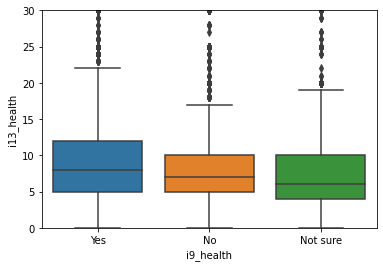

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="i13_health", x="i9_health", data=df_new)
ax.set(ylim=(0, 30))

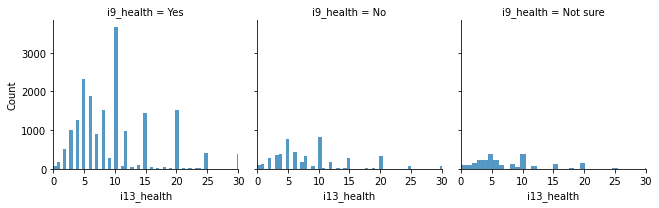

In [ ]:
cond_plot = sns.FacetGrid(data=df_new, col='i9_health', col_wrap=4)
cond_plot.map(sns.histplot, 'i13_health')
cond_plot.set(xlim=(0,30))

In [ ]:
# one-way anova between i13_health and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['i13_health'], df_new[df_new['i9_health'] == 'No']['i13_health'], df_new[df_new['i9_health'] == 'Not sure']['i13_health'])
print(fvalue, pvalue)

3.9476644758600266 0.01931090991007709


### Weight

[(0.0, 2.0)]

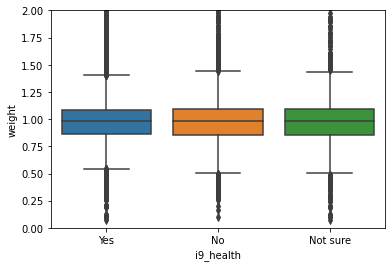

In [ ]:
ax, figure = plt.subplots()
ax = sns.boxplot(y="weight", x="i9_health", data=df_new)
ax.set(ylim=(0, 2))

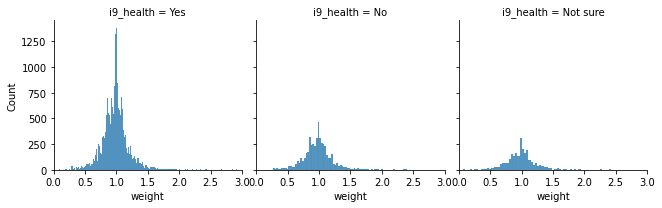

In [ ]:
cond_plot = sns.FacetGrid(data=df_new, col='i9_health', col_wrap=4)
cond_plot.map(sns.histplot, 'weight')
cond_plot.set(xlim=(0,3))

In [ ]:
# one-way anova between weight and i9_health
fvalue, pvalue = stats.f_oneway(df_new[df_new['i9_health'] == 'Yes']['weight'], df_new[df_new['i9_health'] == 'No']['weight'], df_new[df_new['i9_health'] == 'Not sure']['weight'])
print(fvalue, pvalue)

11.678309067814913 8.518755384799767e-06


# Modeling



> **Dummy Variable**



In [ ]:
# dummy variable creation
df_dummy = df_new
df_dummy['i9_health'] = df_dummy['i9_health'].replace(['Yes'],1)
df_dummy['i9_health'] = df_dummy['i9_health'].replace(['No'],2)
df_dummy['i9_health'] = df_dummy['i9_health'].replace(['Not sure'],3)
dummy_cols = cat_cols.copy()
dummy_cols.remove('i9_health')
for var in dummy_cols:
    dummy = pd.get_dummies(df_dummy[var], prefix = var)
    df_dummy = pd.concat([df_dummy, dummy], axis = 1)
    df_dummy = df_dummy.drop(columns = var)



> Train-Test Split



In [ ]:
#split data
array = df_dummy.values
y = array[:,3]
array_X = df_dummy.drop(['i9_health'], axis = 1).values
X = array_X
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = test_size, random_state=seed)



> Balance Training set



In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[1.0000e+00 1.5443e+04]
 [2.0000e+00 4.0240e+03]
 [3.0000e+00 2.0480e+03]]


notice data are not balanced

In [ ]:
# undersampling
undersample = RandomUnderSampler(sampling_strategy='all', random_state=42)
# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
unique, counts = np.unique(y_train_under, return_counts=True)
print(np.asarray((unique, counts)).T)

[[1.000e+00 2.048e+03]
 [2.000e+00 2.048e+03]
 [3.000e+00 2.048e+03]]




> Standardize training set



In [ ]:
# standardize
scalar = StandardScaler().fit(X_train_under)
rescaledX_train_under = scalar.transform(X_train_under)

now we can start training the model using rescaledX_train_under and y_train_under



> Optimal K



In [ ]:
k_values = np.arange(1,25)
param_grid = dict(n_neighbors=k_values, weights=['uniform', 'distance'])
model = KNeighborsClassifier()
kfold= KFold(n_splits = 10, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid = param_grid, scoring = 'accuracy', cv=kfold)
grid_result = grid.fit(rescaledX_train_under, y_train_under)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.512853 using {'n_neighbors': 21, 'weights': 'distance'}


Text(0, 0.5, 'accuracy')

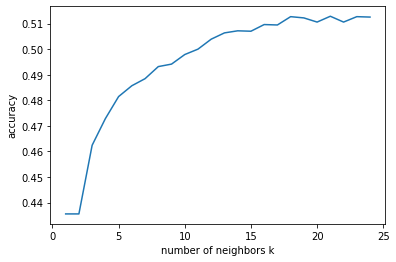

In [ ]:
means = grid_result.cv_results_['mean_test_score'][1::2]
plt.plot(k_values, means)
plt.xlabel("number of neighbors k")
plt.ylabel("accuracy")

When k = 21, the model achieve the highest accuracy.



> Model Performance



In [ ]:
model = KNeighborsClassifier(n_neighbors=21, weights='distance')
model.fit(rescaledX_train_under, y_train_under)
rescaledX_test = scalar.transform(X_test)

In [ ]:
estimates = model.predict(rescaledX_test)

In [ ]:
confusion_matrix(y_test, estimates)

array([[2965,  637,  232],
       [ 425,  445,  165],
       [ 186,  130,  194]])

In [ ]:
matrix = classification_report(y_test,estimates)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

         1.0       0.83      0.77      0.80      3834
         2.0       0.37      0.43      0.40      1035
         3.0       0.33      0.38      0.35       510

    accuracy                           0.67      5379
   macro avg       0.51      0.53      0.52      5379
weighted avg       0.69      0.67      0.68      5379

